In [ ]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving EuroSAT (1).zip to EuroSAT (1).zip


In [ ]:
!unzip EuroSAT.zip

Streaming output truncated to the last 5000 lines.
  inflating: 2750/SeaLake/SeaLake_2206.jpg  
  inflating: 2750/SeaLake/SeaLake_1313.jpg  
  inflating: 2750/SeaLake/SeaLake_263.jpg  
  inflating: 2750/SeaLake/SeaLake_967.jpg  
  inflating: 2750/SeaLake/SeaLake_515.jpg  
  inflating: 2750/SeaLake/SeaLake_1465.jpg  
  inflating: 2750/SeaLake/SeaLake_1817.jpg  
  inflating: 2750/SeaLake/SeaLake_2902.jpg  
  inflating: 2750/SeaLake/SeaLake_2570.jpg  
  inflating: 2750/SeaLake/SeaLake_1004.jpg  
  inflating: 2750/SeaLake/SeaLake_174.jpg  
  inflating: 2750/SeaLake/SeaLake_2111.jpg  
  inflating: 2750/SeaLake/SeaLake_2388.jpg  
  inflating: 2750/SeaLake/SeaLake_1948.jpg  
  inflating: 2750/SeaLake/SeaLake_838.jpg  
  inflating: 2750/SeaLake/SeaLake_2738.jpg  
  inflating: 2750/SeaLake/SeaLake_1999.jpg  
  inflating: 2750/SeaLake/SeaLake_2359.jpg  
  inflating: 2750/SeaLake/SeaLake_2660.jpg  
  inflating: 2750/SeaLake/SeaLake_1775.jpg  
  inflating: 2750/SeaLake/SeaLake_605.jpg  
  inflatin

In [ ]:
ls


2750/  EuroSAT.zip  sample_data/


In [ ]:
!ls 2750

AnnualCrop  HerbaceousVegetation  Industrial  PermanentCrop  River
Forest	    Highway		  Pasture     Residential    SeaLake


In [ ]:
!mv "EuroSAT (1).zip" EuroSAT.zip

In [ ]:
import os
import shutil

# Remove old folder if exists
!rm -rf land_3class

os.makedirs("land_3class/Agriculture", exist_ok=True)
os.makedirs("land_3class/Forest", exist_ok=True)
os.makedirs("land_3class/Urban", exist_ok=True)

# Agriculture classes
agri_classes = ["AnnualCrop", "PermanentCrop", "Pasture", "HerbaceousVegetation"]

# Urban classes
urban_classes = ["Residential", "Industrial", "Highway"]

# Copy Agriculture
for cls in agri_classes:
    for file in os.listdir(f"2750/{cls}"):
        shutil.copy(f"2750/{cls}/{file}", "land_3class/Agriculture")

# Copy Forest
for file in os.listdir("2750/Forest"):
    shutil.copy(f"2750/Forest/{file}", "land_3class/Forest")

# Copy Urban
for cls in urban_classes:
    for file in os.listdir(f"2750/{cls}"):
        shutil.copy(f"2750/{cls}/{file}", "land_3class/Urban")

print("3-Class Dataset Created Successfully!")

3-Class Dataset Created Successfully!


In [ ]:
import random

def limit_images(folder, max_images=3000):
    for cls in os.listdir(folder):
        path = os.path.join(folder, cls)
        images = os.listdir(path)
        if len(images) > max_images:
            remove_images = random.sample(images, len(images)-max_images)
            for img in remove_images:
                os.remove(os.path.join(path, img))

limit_images("land_3class", 3000)
print("Dataset Balanced!")

Dataset Balanced!


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 160   # slightly larger for better accuracy
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    "land_3class",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_data = datagen.flow_from_directory(
    "land_3class",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

Found 7200 images belonging to 3 classes.
Found 1800 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(3, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 93s 337ms/step - accuracy: 0.8624 - loss: 0.3335 - val_accuracy: 0.9178 - val_loss: 0.2238
Epoch 2/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 55s 242ms/step - accuracy: 0.9385 - loss: 0.1687 - val_accuracy: 0.9200 - val_loss: 0.1948
Epoch 3/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 57s 253ms/step - accuracy: 0.9481 - loss: 0.1344 - val_accuracy: 0.9161 - val_loss: 0.2217
Epoch 4/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 62s 276ms/step - accuracy: 0.9548 - loss: 0.1259 - val_accuracy: 0.9089 - val_loss: 0.2140
Epoch 5/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 54s 239ms/step - accuracy: 0.9549 - loss: 0.1165 - val_accuracy: 0.9183 - val_loss: 0.2067


In [ ]:
from tensorflow.keras.optimizers import Adam

base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

fine_history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=3
)

Epoch 1/3
225/225 ━━━━━━━━━━━━━━━━━━━━ 81s 282ms/step - accuracy: 0.8031 - loss: 0.7075 - val_accuracy: 0.9061 - val_loss: 0.2221
Epoch 2/3
225/225 ━━━━━━━━━━━━━━━━━━━━ 56s 249ms/step - accuracy: 0.9204 - loss: 0.2416 - val_accuracy: 0.9172 - val_loss: 0.2158
Epoch 3/3
225/225 ━━━━━━━━━━━━━━━━━━━━ 57s 251ms/step - accuracy: 0.9354 - loss: 0.1842 - val_accuracy: 0.9161 - val_loss: 0.2309


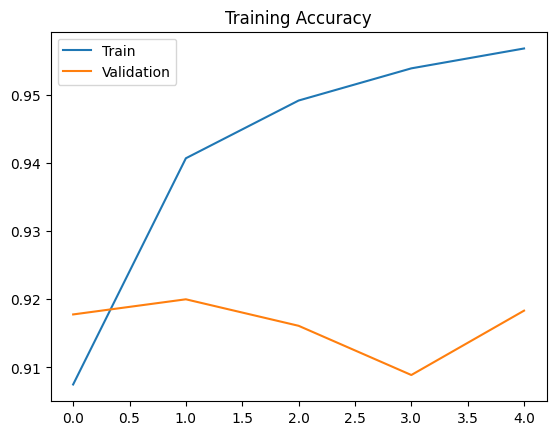

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label="Train")
plt.plot(history.history['val_accuracy'], label="Validation")
plt.title("Training Accuracy")
plt.legend()
plt.show()


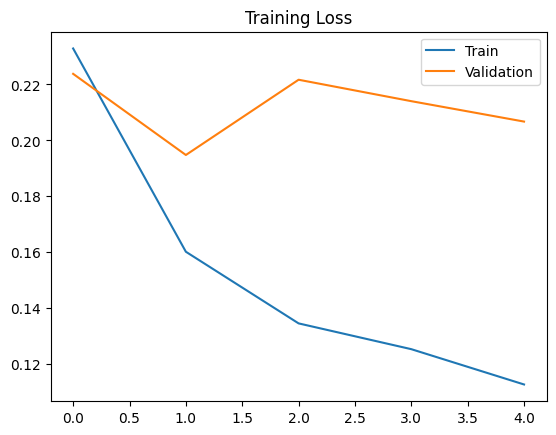

In [ ]:
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Validation")
plt.title("Training Loss")
plt.legend()
plt.show()

57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 262ms/step


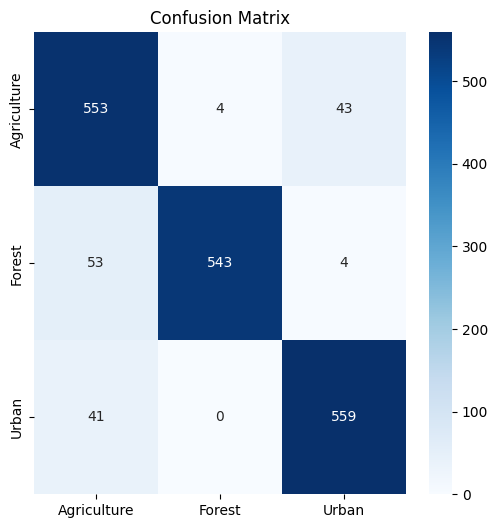

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

val_data.reset()
pred = model.predict(val_data)
pred_classes = np.argmax(pred, axis=1)

true_classes = val_data.classes
class_labels = list(val_data.class_indices.keys())

cm = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_labels,
            yticklabels=class_labels,
            cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

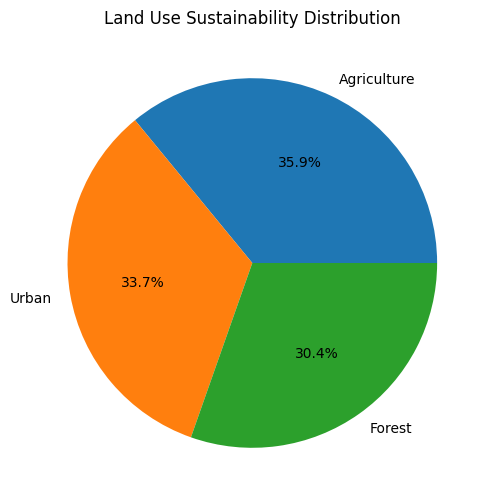

In [ ]:
import matplotlib.pyplot as plt

# Count predicted labels
import pandas as pd
predicted_labels = [class_labels[i] for i in pred_classes]
df = pd.DataFrame({"Predicted": predicted_labels})
counts = df["Predicted"].value_counts()

# Pie Chart
plt.figure(figsize=(6,6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
plt.title("Land Use Sustainability Distribution")
plt.show()

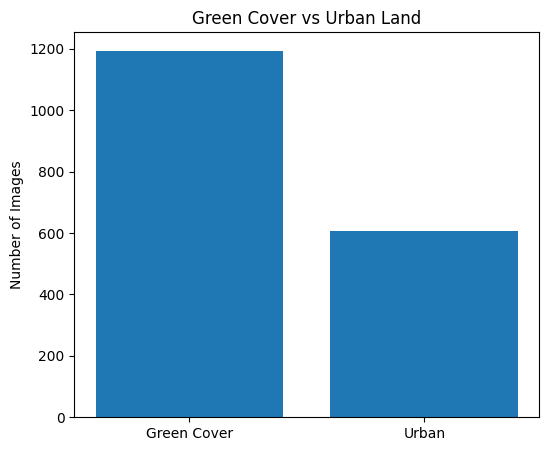

In [ ]:
green_cover = counts["Agriculture"] + counts["Forest"]
urban_cover = counts["Urban"]

plt.figure(figsize=(6,5))
plt.bar(["Green Cover", "Urban"], [green_cover, urban_cover])
plt.title("Green Cover vs Urban Land")
plt.ylabel("Number of Images")
plt.show()

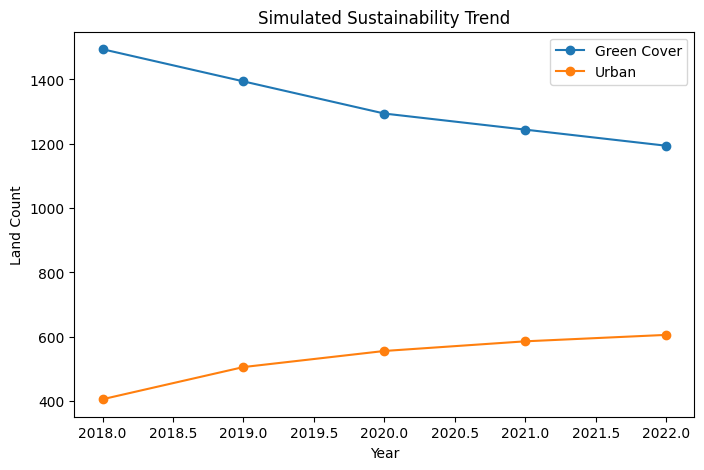

In [ ]:
years = [2018, 2019, 2020, 2021, 2022]

green_trend = [
    green_cover + 300,
    green_cover + 200,
    green_cover + 100,
    green_cover + 50,
    green_cover
]

urban_trend = [
    urban_cover - 200,
    urban_cover - 100,
    urban_cover - 50,
    urban_cover - 20,
    urban_cover
]

plt.figure(figsize=(8,5))
plt.plot(years, green_trend, marker='o', label="Green Cover")
plt.plot(years, urban_trend, marker='o', label="Urban")
plt.title("Simulated Sustainability Trend")
plt.xlabel("Year")
plt.ylabel("Land Count")
plt.legend()
plt.show()

In [ ]:

green_cover = counts["Agriculture"] + counts["Forest"]
urban_cover = counts["Urban"]

In [ ]:
years = [2018, 2019, 2020, 2021, 2022]

green_trend = [
    green_cover + 300,
    green_cover + 200,
    green_cover + 100,
    green_cover + 50,
    green_cover
]

urban_trend = [
    urban_cover - 200,
    urban_cover - 100,
    urban_cover - 50,
    urban_cover - 20,
    urban_cover
]

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

years_np = np.array(years).reshape(-1,1)

green_model = LinearRegression().fit(years_np, green_trend)
urban_model = LinearRegression().fit(years_np, urban_trend)

future_year = np.array([[2025]])

green_2025 = green_model.predict(future_year)[0]
urban_2025 = urban_model.predict(future_year)[0]

print("Predicted Green Cover 2025:", round(green_2025))
print("Predicted Urban Land 2025:", round(urban_2025))

Predicted Green Cover 2025: 949
Predicted Urban Land 2025: 772


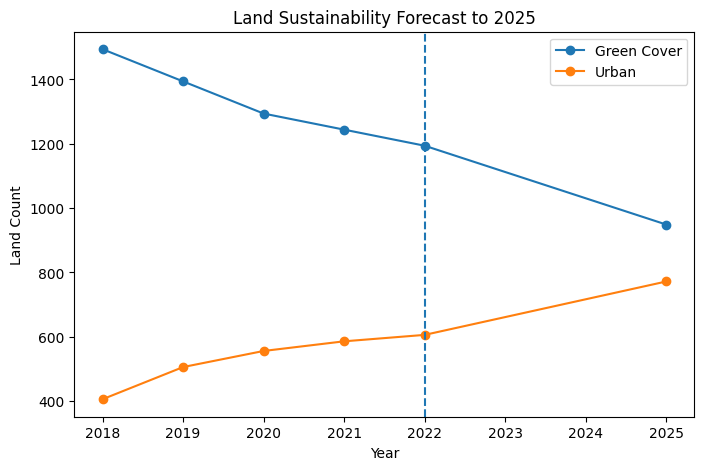

In [ ]:
future_years = years + [2025]
future_green = green_trend + [green_2025]
future_urban = urban_trend + [urban_2025]

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(future_years, future_green, marker='o', label="Green Cover")
plt.plot(future_years, future_urban, marker='o', label="Urban")

plt.axvline(x=2022, linestyle='--')  # separates real vs predicted

plt.title("Land Sustainability Forecast to 2025")
plt.xlabel("Year")
plt.ylabel("Land Count")
plt.legend()
plt.show()